In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Final Hackathon

## <div style="padding: 30px;color:white;margin:00px;font-size:60%;text-align:left;border-radius:10px;background-color:#686dec;overflow:hidden"><b><span style='color:white'>1 |</span></b> <b> ВВЕДЕНИЕ</b></div>

### <b><span style='color:#686dec'> Финальный хакатон</span></b> 

- В качестве финального хакатона мы подготовили для вас соревнование по предсказанию рейтинга отзыва в интернет-магазине. 
- Соревнование реализовано на площадке kaggle. 
- Для соревнования используется датасет **отзывов с Amazon Kindle Store**

### <b><span style='color:#686dec'> Постановки Задачи</span></b> 

- В этом ноуте мы рассмотрим пример **NLP задачю** классификации. 
- Нам предстоит создать модель которая может **предсказывать рейтинг товара**, на основе имеющихся данных

## <div style="padding: 30px;color:white;margin:00px;font-size:60%;text-align:left;border-radius:10px;background-color:#686dec;overflow:hidden"><b><span style='color:white'>2 |</span></b> <b> ДАННЫЕ</b></div>

### <b><span style='color:#686dec'>Чтение данных</span> </b> 

Начнем с чиением данных тренировочной и тестовой выборки, тестовую выборку мы будем использовать для **тренировки** и **валидации** модели, а тестовую выборку мы будем использовать для предсказания.


In [36]:
train = pd.read_csv('/kaggle/input/sf-review-stars-prediction/train.csv',index_col=0).drop(columns='Unnamed: 0.1')
test = pd.read_csv('/kaggle/input/sf-review-stars-prediction/test.csv',index_col=0).drop(columns='Unnamed: 0.1')

### <b><span style='color:#686dec'>Обзор данных</span> </b> 

Опишим остновные признаки

- `ID` - идентификационный признак (нужен для сабмита)
- `asin` - ID товара, например B000FA64PK
- `helpful` - полезность рейтинга по мнению других пользователей, например 2/3.
- `reviewText` - заголовок отзыва.
- `reviewTime` - время создания отзыва.
- `reviewerID` - ID автора отзыва, например A3SPTOKDG7WBLN.
- `reviewerName` - имя автора отзыва.
- `summary` - сжатое содержание отзыва.
- `unixReviewTime` - время создания отзыва в виде timestamp.
- `overall` - рейтинг товара – целевая переменная.
- `features` - BERT эмбеддинги `reviewText`


In [37]:
train.head()

,ID,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,features
0,0,B000F83SZQ,"[0, 0]",5.0,I enjoy vintage books and movies so I enjoyed ...,"05 5, 2014",A1F6404F1VG29J,Avidreader,Nice vintage story,1399248000,"[-1.2551e-01, 2.7282e-02, -3.9638e-02, -8.9909..."
1,1,B000F83SZQ,"[2, 2]",4.0,This book is a reissue of an old one; the auth...,"01 6, 2014",AN0N05A9LIJEQ,critters,Different...,1388966400,"[ 3.6394e-01, -5.9243e-02, 1.0343e-01, -3.1970..."
2,2,B000F83SZQ,"[2, 2]",4.0,This was a fairly interesting read. It had ol...,"04 4, 2014",A795DMNCJILA6,dot,Oldie,1396569600,"[ 2.8251e-01, -3.5420e-02, -4.2864e-01, 3.1264..."
3,3,B000F83SZQ,"[1, 1]",5.0,I'd never read any of the Amy Brewster mysteri...,"02 19, 2014",A1FV0SX13TWVXQ,"Elaine H. Turley ""Montana Songbird""",I really liked it.,1392768000,"[-7.1293e-01, -2.7817e-01, 5.6167e-01, -6.9253..."
4,4,B000F83SZQ,"[0, 1]",4.0,"If you like period pieces - clothing, lingo, y...","03 19, 2014",A3SPTOKDG7WBLN,Father Dowling Fan,Period Mystery,1395187200,"[ 3.9603e-01, 5.1992e-01, -8.5361e-01, 7.7056e..."


Разница признаков между тренировочной и тестовой выборки, очевидно что `overall` является целевым признаком

In [38]:
set(list(train.columns))-set(list(test.columns))

{'overall'}

Посмотрим на распределение данных в целевом признаке
- Оценка обзора является ординалным признаком (1-5)
- Данных обзоров с низкой оценкой (1-2) не так много по сравнению с оценками (3-5)

In [39]:
train['overall'].value_counts()

5.0    503
4.0    261
3.0    140
2.0     53
1.0     43
Name: overall, dtype: int64

## <div style="padding: 30px;color:white;margin:00px;font-size:60%;text-align:left;border-radius:10px;background-color:#686dec;overflow:hidden"><b><span style='color:white'>3 |</span></b> <b> РАЗВЕДОВАТЕЛЬНЫЙ АНАЛИЗ</b></div>


### <b><span style='color:#686dec'>Автор обзора</span> </b> 

Давайте иследуем распределение авторов в тренировочной и тестовой выборке

In [40]:
reviewers_train = list(train['reviewerID'].unique())
reviewers_test = list(test['reviewerID'].unique())
reviewers_all = reviewers_train + reviewers_test
print(len(reviewers_train),len(reviewers_test),len(reviewers_all),len(set(reviewers_all)))

827 949 1776 1758


### <b><span style='color:#686dec'> Предмет обзора</span></b> 

Теперь посмотрим на распределение данных в обоих выборок для фичи `asin` (ID товара)

In [41]:
train['asin'].value_counts()
# items_all +=list(test['asin'].nunique())

B000JMLBHU    108
B000R93D4Y     50
B000WSFBO0     41
B000NJL7Y6     24
B000JMLHYC     23
             ... 
B000JML5JY      5
B000UH5Z3A      5
B000UH5Z0I      5
B000SIZG8A      5
B000TU16PE      5
Name: asin, Length: 93, dtype: int64

In [42]:
test['asin'].value_counts()

B00CBJXM1M    55
B00CBFZVU6    49
B00CB7NHC8    43
B00CBL9IOK    41
B00CB3SH0O    35
              ..
B00CB2CG1Q     5
B00CB26IBK     5
B00CB26IA6     5
B00CB26G7G     5
B00CB1OPI4     3
Name: asin, Length: 73, dtype: int64

### <b><span style='color:#686dec'>Времменные признаки</span> </b> 

- У нас есть два признака связанные с временем; `ubixReviewTime` & `reviewTimez`
- Из одного из них мы можем получить дополнительные признаки через атрибут `dt`, другой нам не нужен
- На основе фичи `unixReviewTime` и создадим эти новые фичи

In [43]:
train.drop(columns=['reviewTime'])
test.drop(columns=['reviewTime'])
train.head()

,ID,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,features
0,0,B000F83SZQ,"[0, 0]",5.0,I enjoy vintage books and movies so I enjoyed ...,"05 5, 2014",A1F6404F1VG29J,Avidreader,Nice vintage story,1399248000,"[-1.2551e-01, 2.7282e-02, -3.9638e-02, -8.9909..."
1,1,B000F83SZQ,"[2, 2]",4.0,This book is a reissue of an old one; the auth...,"01 6, 2014",AN0N05A9LIJEQ,critters,Different...,1388966400,"[ 3.6394e-01, -5.9243e-02, 1.0343e-01, -3.1970..."
2,2,B000F83SZQ,"[2, 2]",4.0,This was a fairly interesting read. It had ol...,"04 4, 2014",A795DMNCJILA6,dot,Oldie,1396569600,"[ 2.8251e-01, -3.5420e-02, -4.2864e-01, 3.1264..."
3,3,B000F83SZQ,"[1, 1]",5.0,I'd never read any of the Amy Brewster mysteri...,"02 19, 2014",A1FV0SX13TWVXQ,"Elaine H. Turley ""Montana Songbird""",I really liked it.,1392768000,"[-7.1293e-01, -2.7817e-01, 5.6167e-01, -6.9253..."
4,4,B000F83SZQ,"[0, 1]",4.0,"If you like period pieces - clothing, lingo, y...","03 19, 2014",A3SPTOKDG7WBLN,Father Dowling Fan,Period Mystery,1395187200,"[ 3.9603e-01, 5.1992e-01, -8.5361e-01, 7.7056e..."


In [44]:
train['day'] = pd.to_datetime(train['unixReviewTime'],unit='s').dt.day
train['month'] = pd.to_datetime(train['unixReviewTime'],unit='s').dt.month
train['dow'] = pd.to_datetime(train['unixReviewTime'],unit='s').dt.dayofweek

test['day'] = pd.to_datetime(test['unixReviewTime'],unit='s').dt.day
test['month'] = pd.to_datetime(test['unixReviewTime'],unit='s').dt.month
test['dow'] = pd.to_datetime(test['unixReviewTime'],unit='s').dt.dayofweek

train = train.drop(columns=['unixReviewTime'],axis=1)
test = test.drop(columns=['unixReviewTime'],axis=1)

### <b><span style='color:#686dec'>Признак помощи</span></b> 

- В данных у нас есть призкак который отображает полезность написанного обзора, который оценивают другие пользователи
- Найдем разницу между положительных и отрицательных оценок
- для этого нам надо конвертировать `str` формат которую содержит csv в `список`

In [45]:
train['helpful']

0      [0, 0]
1      [2, 2]
2      [2, 2]
3      [1, 1]
4      [0, 1]
        ...  
995    [0, 0]
996    [0, 0]
997    [0, 0]
998    [0, 0]
999    [0, 0]
Name: helpful, Length: 1000, dtype: object

In [46]:
train['helpful'] = train['helpful'].apply(lambda row: eval(row))
train['helpful'] = train['helpful'].apply(lambda row: row[0] - (row[1] - row[0]))

### <b><span style='color:#686dec'>Признаки BERT</span></b> 

- Нам дали данные **hidden state** модели BERT, скорее всего **средний вектор** всех эмбеддингов в каждом документе в `ReviewText`
- Данные векторов сохранялись в `DataFrame`, и читаются как `str`, воспользуемся `eval` для каждой строки

In [47]:
print(train['features'][0][:100])
print(type(train['features'][0][:100])) 
type(eval(train['features'][0]))  # список данных 

[-1.2551e-01, 2.7282e-02, -3.9638e-02, -8.9909e-02, 6.7109e-01, -3.5082e-01, -4.4905e-01, 4.4430e-01
<class 'str'>


list

Это превращает `str` в список `list` , далее превращаем данные в `np.array`

In [48]:
train['features'] = train['features'].apply(lambda row:np.array(eval(row)))
test['features'] = test['features'].apply(lambda row:np.array(eval(row)))

## <div style="padding: 30px;color:white;margin:00px;font-size:60%;text-align:left;border-radius:10px;background-color:#686dec;overflow:hidden"><b><span style='color:white'>4 |</span></b> <b> ПРЕОБРАБОТКА ТЕКСТА</b></div>

- Мы можем использовать текстовые данные для создания фичеров
- Для этого нам надо будет обработать **текстовые данные** и преобразовать их в **цифровые данные**
- Воспользуемся методом **TF-IDF** **TfidfVectorizer** (Один из методов мешок слов
- Из каждого документа убираем часто всречающийся слова **stopwords**

In [49]:
train['reviewText']

0      I enjoy vintage books and movies so I enjoyed ...
1      This book is a reissue of an old one; the auth...
2      This was a fairly interesting read.  It had ol...
3      I'd never read any of the Amy Brewster mysteri...
4      If you like period pieces - clothing, lingo, y...
                             ...                        
995    I enjoyed reading this story.  The characters ...
996    This was a fun book to read for the 2nd time. ...
997    Or just a Christmas romance to make you crack-...
998    I read "Stop the wedding" by this author and w...
999    This was one of the funniest books I have ever...
Name: reviewText, Length: 1000, dtype: object

- `TfidfVectorizer` используем с стоп словми `stop_words`
- Так же мы заменем всю пунктуацию на пустое значение 

In [ ]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

# stubstitute stop words with ''
vectoriser = TfidfVectorizer(stop_words=[re.sub(r'[a-zA-Z_0-9\s]',r'',sw) for sw in stop_words])

X_train = vectoriser.fit_transform(train['reviewText'].apply(lambda row: re.sub(r'[^a-zA-Z_0-9\s]',r'',row)))
X_test = vectoriser.transform(test['reviewText'].apply(lambda row: re.sub(r'[^a-zA-Z_0-9\s]',r'',row)))

На выходе у нас sparse матрица с словарем размером 9545 слов

In [51]:
X_train

<1000x9545 sparse matrix of type '<class 'numpy.float64'>'
	with 59480 stored elements in Compressed Sparse Row format>

In [75]:
y = train['overall']
y

0      5.0
1      4.0
2      4.0
3      5.0
4      4.0
      ... 
995    5.0
996    4.0
997    5.0
998    1.0
999    5.0
Name: overall, Length: 1000, dtype: float64

## <div style="padding: 30px;color:white;margin:00px;font-size:60%;text-align:left;border-radius:10px;background-color:#686dec;overflow:hidden"><b><span style='color:white'>5 |</span></b> <b> NLP МОДЕЛИ</b></div>

### <b><span style='color:#686dec'> Проверка качества обучающей выборки</span></b> 

- Нам предстоит использовать метрику `MAE`, но мы все равно можем расматривать задачу как задачу многоклассовой классификации текса, для этого мы можем использовать `reviewText` и извлеч из нее фичи, что мы и сделали 
- Нам нужно изучить насколько хорошо работают разные модельные подходы, все вариатны которые будем обучать сохраним в список `lst_models`
- `nlp_evals` дает нам возможность проверить качество `перекресточной валидации` и `train-test split` подходы, в классе герерируются TF-IDF вектора, как и в предыдущем разделе
- Использовать будем модели классификации но оценивать будем метрику `MAE`
- Разбиене происходит только на подвыборке `train`, оценив `MAE` на оценим качество и на тестовой выборке `test` в следующем разделе

In [53]:
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.ensemble  import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

rs = 42

lst_models = []
clf = RandomForestClassifier(n_estimators=10,max_depth=100,random_state=34567)
clf2 = ExtraTreesClassifier(random_state=rs)
clf3 = AdaBoostClassifier(random_state=rs)

ber = BernoulliNB(alpha=1)
com = ComplementNB(alpha=0.1)
mn = MultinomialNB(alpha=0.01)
rc = RidgeClassifier(alpha=0.1,tol=1e-4,solver='auto',random_state=rs)

lst_models.append(('rfc',clf))
lst_models.append(('etc',clf2))
lst_models.append(('ada',clf3))
lst_models.append(('ber',ber))
lst_models.append(('com',com))
lst_models.append(('mn',mn))
lst_models.append(('rc',rc))

In [54]:
import warnings; warnings.filterwarnings('ignore')
import seaborn as sns; 
sns.set_style("whitegrid", {
    "ytick.major.size": 0.1,
    "ytick.minor.size": 0.05,
    'grid.linestyle': '--'
 })
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from copy import deepcopy
import spacy
import en_core_web_lg

def hex_to_rgb(h):
    h = h.lstrip('#')
    return tuple(int(h[i:i+2], 16)/255 for i in (0, 2, 4))

palette = ['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252']
palette_rgb = [hex_to_rgb(x) for x in palette]


class nlp_evals:
    
    def __init__(self,df,corpus,label,
                 spacy_model='en_core_web_lg',
                 title='accuracy evaluation'
                ):
        
        self.df = deepcopy(df)
        self.corpus = corpus
        self.label = label
        
        # spacy embedding not utilised
        self.spacy_model = spacy_model
        
        # generate TF-IDF features
        self.features = self.get_tfidf()
        self.seed = 32
        self.num_folds = 6
        self.title = title
    
    @staticmethod
    def criterion(y,ypred):
        return MAE(y,ypred)
    
    # TF-IDF vectors
    def get_tfidf(self):
        
        stop_words = stopwords.words('english')
        vectoriser = TfidfVectorizer(stop_words=[re.sub(r'[a-zA-Z_0-9\s]',r'',sw) for sw in stop_words])
        X_train = vectoriser.fit_transform(self.df[self.corpus].apply(lambda row: re.sub(r'[^a-zA-Z_0-9\s]',r'',row)))
        print(X_train.shape) 
        return X_train
        
    # spacy embeddings
    def get_embeddings(self):
        
        # NLP pipline
        nlp = spacy.load(self.spacy_model)
        if(self.spacy_model is 'en_core_web_sm'):
            embedding_dims = 96
        elif(self.spacy_model is 'en_core_web_lg'):
            embedding_dims = 300
        
        # average embedding vector for each document
        all_vectors = np.array([np.array([token.vector for token in nlp(s) ]).mean(axis=0)*np.ones((embedding_dims)) \
                                   for s in self.df[self.corpus]])
        print(all_vectors.shape)
        print('embeddings loaded!')
        return all_vectors
        
    def tts(self,ratio=0.2):
        
        # split out validation dataset for the end
        Y = self.df[self.label]
        X = self.features

        X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                            test_size=ratio, 
                                                            random_state=42)
        
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train 
        self.y_test = y_test
        print('train/test split!')
        
    def define_models(self,models):
        self.models = models
        print('models set!')
        
    def kfold(self):
        
        self.results = []
        self.names = []
        self.test_results = []
        self.train_results = []
        self.cv_results = []
        
        lX_train = deepcopy(self.X_train)
        lX_test = deepcopy(self.X_test)
        ly_train = deepcopy(self.y_train.to_frame())
        ly_test = deepcopy(self.y_test.to_frame())
    
        self.lst_names = []
        for name, model in self.models:
            
            self.lst_names.append(name)
            
            # cross validation on training dataset
            kfold = KFold(n_splits=self.num_folds, shuffle=True,random_state=self.seed)
            cv_results = cross_val_score(model, 
                                         self.X_train, self.y_train,
                                         cv=kfold,
                                         scoring='neg_mean_absolute_error')
            self.results.append(cv_results)
            self.names.append(name)
            self.cv_results.append(abs(cv_results.mean()))

           # Full Training period
            res = model.fit(self.X_train, self.y_train)
            ytrain_res = res.predict(self.X_train)
            criterion_train = self.criterion(ytrain_res,self.y_train)
            self.train_results.append(criterion_train)

            # Test results
            ytest_res = res.predict(self.X_test)
            criterion_test = self.criterion(ytest_res, self.y_test)
            self.test_results.append(criterion_test)    

            msg = "%s: %f (%f) %f %f" % (name, 
                                         cv_results.mean(), 
                                         cv_results.std(), 
                                         criterion_train, 
                                         criterion_test)
            
            ly_train[f'{name}_train'] = ytrain_res
            ly_test[f'{name}_test'] = ytest_res
            
            # print(msg)
            # print(confusion_matrix(ytest_res, self.y_test))
            
        
        self.ly_train = ly_train
        self.ly_test = ly_test
        
        self.plot_results()
            
        print('evaluation finished!')
        
    def plot_results(self):

        ldf_res = pd.DataFrame({'cv':self.cv_results,
                                'train':self.train_results,
                                'test':self.test_results})
        
        plot_df = ldf_res.melt()
        local_names = deepcopy(self.names)
        local_names = local_names * 3
      
        plot_df['names'] = local_names
        
        ptable = pd.pivot_table(plot_df,
                                values='value',
                                index='variable',
                                columns='names')

        fig,ax = plt.subplots(1,2,figsize=(12,3))
        sns.heatmap(ptable,annot=True,
                    fmt=".2f",
                    cmap='crest',
                    linewidth=3,
                    ax=ax[0])
        
        sns.boxplot(data=self.results,orient="v",
                   width=0.2,ax=ax[1],palette=palette_rgb)
            
        ax[1].set_xticklabels(self.lst_names)
        sns.stripplot(data=self.results,ax=ax[1], orient='v',color=".3",linewidth=1)
        ax[1].set_xticklabels(self.lst_names) 
        
        sns.despine(left=True, bottom=True,ax=ax[1])
        plt.title(self.title)

Обучаем наши модели на `train` подвыборке

(1000, 9545)
train/test split!
models set!
evaluation finished!


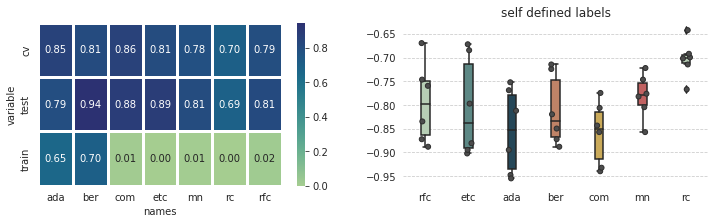

In [55]:
# instantiate new evalation class

evals_nlp = nlp_evals(df=train,            # define the corpus dataframe
                      corpus='reviewText', # define which column contains the corpus
                      label='overall',  # define the column which contains the label
                      title='self defined labels') 

evals_nlp.tts()
evals_nlp.define_models(lst_models)
evals_nlp.kfold()

### <b><span style='color:#686dec'> Обучаем модели</span></b> 

Проверив качество моделей на разных подвыборках, давайте оценим качество на всей обучающей выборке и на тестовой выборке

In [56]:
tr_X = X_train[:-200]; tr_y = y[:-200]
te_X = X_train[-200:]; te_y = y[-200:]

# RF
clf.fit(tr_X,tr_y)
y_pred = clf.predict(te_X)
MAE(te_y,y_pred)

0.72

In [57]:
# ET
clf2.fit(tr_X,tr_y)
y_pred2 = clf2.predict(te_X)
MAE(te_y,y_pred2)

0.72

In [58]:
# AdaBoost
clf3.fit(tr_X,tr_y)
y_pred3 = clf3.predict(te_X)
MAE(te_y,y_pred3)

0.83

In [59]:
# Bernoulli Naive Bayes
ber.fit(tr_X,tr_y)
y_pred_ber = ber.predict(te_X)
MAE(te_y,y_pred_ber)

0.735

In [60]:
# Complement Naive Bayes
com.fit(tr_X,tr_y)
y_pred_com = com.predict(te_X)
MAE(te_y,y_pred_com)

0.83

In [61]:
# Multinomial Naive Bayes
mn.fit(tr_X,tr_y)
y_pred_mn = mn.predict(te_X)
MAE(te_y,y_pred_mn)

0.685

In [62]:
# Ridge Regression
rc.fit(tr_X,tr_y)
y_pred_rc = rc.predict(te_X)
MAE(te_y,y_pred_rc)

0.565

Создадим простые ансамбли ответов



In [63]:
y_pred_1 = mn.predict(te_X)
y_pred_2 = rc.predict(te_X)
y_pred_blend = (y_pred_1 + y_pred_2)/2
MAE(te_y,y_pred_blend)

0.59

In [64]:
y_test_rc = rc.predict(X_test)
y_test_mn = mn.predict(X_test)
y_pred = (y_test_rc + y_test_mn)/2

In [65]:
submission = pd.DataFrame({
     'ID': test.ID,
    'overall': y_pred
 })
submission.to_csv('submission_1.csv', index=None)

## <div style="padding: 30px;color:white;margin:00px;font-size:60%;text-align:left;border-radius:10px;background-color:#686dec;overflow:hidden"><b><span style='color:white'>6 |</span></b> <b> BERT ЭМБЕДДИНГ МОДЕЛИ</b></div>

Попробуем альтернативный подход:
- У нас есть эмбеддинги из модели `BERT` для тектовых данных колонки `reviewText`
- Тексту сопостовляются вектора размером 50, те. смысл содержания обзора в компактом виде можно упоковать, это намного эффективнее чем TF-IDF.
- Посмотрим сможем ли мы улучшить качество моделей таким подходом

#### Обучем модели только на признаках эмбеддингов

In [66]:
# len(json.loads(train_df['features'].iloc[0])) # dimensionality of encoder layers and pooler layer (hidden size)
# train_features = np.stack(train.features.apply(json.loads))
# test_features = np.stack(test.features.apply(json.loads))
# train_features.shape

train_features_bert = np.stack(train['features'])      # training data
test_features_bert = np.stack(test['features'])        # test data
train_features_bert.shape, test_features_bert.shape

tr_X_bert = train_features_bert[:-200]; tr_y_bert = y[:-200]
te_X_bert = train_features_bert[-200:]; te_y_bert = y[-200:]

In [67]:
clf = RandomForestClassifier(n_estimators=10,max_depth=100,random_state=34567)
clf2 = ExtraTreesClassifier(random_state=rs)
clf3 = AdaBoostClassifier(random_state=rs)

ber = BernoulliNB(alpha=1)
com = ComplementNB(alpha=0.1)
mn = MultinomialNB(alpha=0.01)
rc = RidgeClassifier(alpha=0.1,tol=1e-4,solver='auto',random_state=rs)

In [68]:
# RF
clf.fit(tr_X_bert,tr_y_bert)
y_pred = clf.predict(te_X_bert)
MAE(te_y_bert,y_pred)

0.925

In [69]:
# Ridge
rc.fit(tr_X_bert,tr_y_bert)
y_pred = rc.predict(te_X_bert)
MAE(te_y_bert,y_pred)

1.07

#### Добавим TF-IDF фичи к эмбеддинговым фичам

Сгрупируем TF-IDF и BERT признаки в одну матрицу

In [70]:
# horizontally stack data (pandas axis=1)
X_all = np.hstack((X_train.toarray(),train_features_bert))
X_all.shape

(1000, 10313)

In [71]:
tr_X_bert = X_all[:-200]; tr_y_bert = y[:-200]
te_X_bert = X_all[-200:]; te_y_bert = y[-200:]

In [72]:
# RF
clf.fit(tr_X_bert,tr_y_bert)
y_pred = clf.predict(te_X_bert)
MAE(te_y_bert,y_pred)

0.74

In [73]:
# Ridge
rc.fit(tr_X_bert,tr_y_bert)
y_pred = rc.predict(te_X_bert)
MAE(te_y_bert,y_pred)

0.93

In [74]:
submission = pd.DataFrame({
   'ID': test.ID,
    'overall': y_pred_blend
})
submission.to_csv('submission.csv', index=None)